In [731]:
import pennylane as qml

import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_friedman2
import time
import torch
import torch.nn as nn
from torch.autograd import Variable
import torch.optim as optim


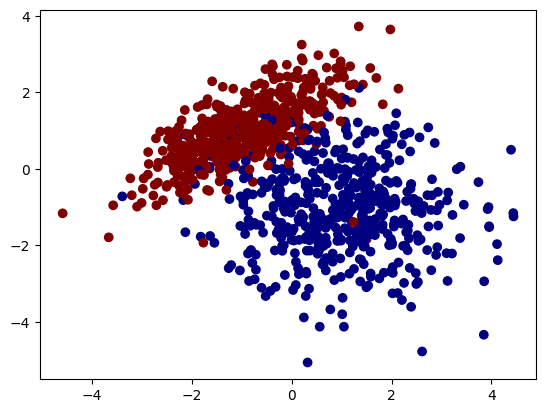

In [740]:
n_features=2
n=1000
X, Y = make_classification(n_samples=n, n_features=n_features, n_redundant=0, n_clusters_per_class=1)
plt.scatter(X[:, 0], X[:, 1], c=Y,cmap='jet')
x = torch.from_numpy(X.astype(np.float32))
y = torch.from_numpy(Y.astype(np.float32)).view(-1,1)


In [709]:
n_qubits = 4
dev = qml.device("lightning.qubit", wires= n_qubits)
# Number of variational layers
q_depth = 2

#Declaration of inputs:
def angle_embedding(inputs):
    for i in range(n_qubits):
        qml.Hadamard(wires = i)
        
    for i in range(n_qubits):
        qml.RY(inputs[(2 * i) ], wires=i)
        qml.RZ(inputs[(2 * i) + 1], wires=i)

def amplitude_embedding(inputs):
    inputs=1/(1+torch.exp(-inputs))
    normalize_input = inputs/torch.sqrt(sum(inputs**2))
    qml.templates.AmplitudeEmbedding(normalize_input , wires=range(n_qubits), pad_with=0)

def basis_embedding(inputs):
    binary_inputs = (inputs >= 0.5).to(torch.int)
    for i in range(n_qubits):
        if binary_inputs[i] == 1:
            qml.PauliX(wires=i)




@qml.qnode(dev, interface='torch')
def qnode(inputs, weights):
    embedding(inputs)
    # Variational circuit
    for i in range(q_depth):
        for j in range(n_qubits):
            qml.RY(weights[2*(i*n_qubits + j) ], wires=j)
            qml.RZ(weights[2*(i*n_qubits + j) + 1], wires=j)
        for l in range(n_qubits):
            if (l == (n_qubits - 1)):
                qml.CNOT(wires=[l,0])
            else:
                qml.CNOT(wires=[l,l+1])

    for k in range(n_qubits):
        qml.RY(weights[(2*q_depth * n_qubits) + k ], wires=k)
        qml.RZ(weights[(2*q_depth * n_qubits) + k + 1], wires=k)

    # Measurement
    return [qml.expval(qml.PauliZ(wires=i)) for i in range(n_qubits)]

In [710]:
n_args = 2*(q_depth +1) * n_qubits
weight_shapes = {"weights": n_args}
# Visualize the circuit
#print(qml.draw(qnode)(inputs = np.random.rand(n_qubits * 2), weights = np.random.rand(n_args)))

In [711]:

class QNet(nn.Module):

    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(n_features, 8)
        self.relu1 = nn.ReLU()
        self.dout = nn.Dropout(0.2)
        self.qlayer_1 = qml.qnn.TorchLayer(qnode, weight_shapes)
        self.relu2 = nn.ReLU()
        self.out = nn.Linear(n_qubits, 1)
        self.out_act = nn.Sigmoid()

    def forward(self, input_):
        a1 = self.fc1(input_)
        h1 = self.relu1(a1)
        dout = self.dout(h1)
        a2 = self.qlayer_1(dout[0])
        h2 = self.relu2(a2.unsqueeze(0))
        a3 = self.out(h2)
        y = self.out_act(a3)
        return y

qnet = QNet()

In [712]:
def train_epoch(model, opt, criterion, X, Y):
    model.train()
    losses = []
    for beg_i in range(0, X.size(0)):
        x_batch = X[beg_i:beg_i + 1, :]
        y_batch = Y[beg_i:beg_i + 1, :]
        x_batch = Variable(x_batch)
        y_batch = Variable(y_batch)

        opt.zero_grad()
        # (1) Forward
        y_hat = model(x_batch)
        # (2) Compute diff
        loss = criterion(y_hat, y_batch)
        # (3) Compute gradients
        loss.backward()
        # (4) update weights
        opt.step()
        losses.append(loss)
    return losses


In [713]:
#Training
#Choose type of embedding=angle_embedding/amplitude_embeddding/basis_embedding
embedding = basis_embedding

q_opt = optim.Adam(qnet.parameters(), lr=0.02, betas=(0.9, 0.999))
criterion = nn.BCELoss()

e_losses_q = []
num_epochs = 10
for e in range(num_epochs):
    e_losses_q += train_epoch(qnet, q_opt, criterion, x, y)
    #if (e % 10 == 0):
        #print(e)
#plt.plot(e_losses_q)


In [714]:
test_pred_q = torch.empty((n,1))
for i in range(0, x.size(0)):
    x_temp = x[i:i + 1, :]
    test_pred_q[i] = torch.round(qnet(x_temp))

In [716]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc
#plt.scatter(X[:, 0], X[:, 1], c=test_pred_q[:, 0].detach().numpy() ,cmap='jet')
accuracy_fn(y, test_pred_q)

91.5

In [717]:
#Training
x = torch.from_numpy(X.astype(np.float32))
y = torch.from_numpy(Y.astype(np.float32)).view(-1,1)
embedding = amplitude_embedding
q_opt = optim.Adam(qnet.parameters(), lr=0.02, betas=(0.9, 0.999))
criterion = nn.BCELoss()
e_losses_q = []
num_epochs = 10

for e in range(num_epochs):
    e_losses_q += train_epoch(qnet, q_opt, criterion, x, y)
    if (e % 10 == 0):
        print(e)
#plt.plot(e_losses_q)


0


In [718]:

test_pred_q = torch.empty((n,1))
for i in range(0, x.size(0)):
    x_temp = x[i:i + 1, :]
    test_pred_q[i] = torch.round(qnet(x_temp))
#plt.scatter(X[:, 0], X[:, 1], c=test_pred_q[:, 0].detach().numpy() ,cmap='jet')
accuracy_fn(y, test_pred_q)

96.1

In [719]:
#Training
x = torch.from_numpy(X.astype(np.float32))
y = torch.from_numpy(Y.astype(np.float32)).view(-1,1)
embedding = angle_embedding
q_opt = optim.Adam(qnet.parameters(), lr=0.02, betas=(0.9, 0.999))
criterion = nn.BCELoss()
e_losses_q = []
num_epochs = 10

for e in range(num_epochs):
    e_losses_q += train_epoch(qnet, q_opt, criterion, x, y)
    if (e % 10 == 0):
        print(e)
#plt.plot(e_losses_q)

#plt.scatter(X[:, 0], X[:, 1], c=test_pred_q[:, 0].detach().numpy() ,cmap='jet')
test_pred_q = torch.empty((n,1))
for i in range(0, x.size(0)):
    x_temp = x[i:i + 1, :]
    test_pred_q[i] = torch.round(qnet(x_temp))
accuracy_fn(y, test_pred_q)

0


94.39999999999999

| embedding | accuracy |
|---|---|
| angle | 94.3% |
|  amplitude |96.1% |
| basis| 91.5% |